# PINNs on Graphs

This notebook accompanies the paper


---

In this notebook, we describe and illustrate the methodology proposed in the aforementioned paper.
Here, we deal with the solution of a drift-diffuion equation on a metric graph.
A metric graph is an undirected graph that consists of a set of vertices $\mathcal V$ and edges $\mathcal E$ where in contrast to combinatorial graphs a length $l_e$ is assigned to each edge $e \in \mathcal E$.
Each edge $e \in \mathcal E$ connects a pair of nodes $(v_{e_a},v_{e_b})$ with $v_{e_a}, v_{e_b} \in \mathcal V$

We consider the drift-diffusion equation posed on each edge

$$
\partial_t u = \partial_x ( \varepsilon \partial_x \rho_e - f(\rho_e) \partial_x V_e), \quad e \in \mathcal E
$$

where $\rho_e : [0,l_e] \times (0,T) \to \mathbb{R}_+$ describes, on each edge, the concentration of some quantity while $V_e: [0,l_e] \times(0,T)\to \mathbb{R}_+$ is a given potential and $\varepsilon > 0$ a given constant, typically small.

To make this a well-posed problem, we need a set of initial conditions as well as coupling conditions in the vertices.
- For vertices $v \in \mathcal V_{\mathcal K} \subset \mathcal V$, we apply homogeneous Neumann-Kirchhoff conditions, i.e., there holds
$$
\sum_{e \in \mathcal{E}_v} J_e \, n_{e} (v) = 0 \quad v \in \mathcal V_{\mathcal K},
$$
where we additionally ask the solution to be continuous over the edges, i.e.
$$
p_e(v) = p_{e^{'}}(v)
\quad \text{for all } v \in \mathcal{V}_{\mathcal K}, e, e^{'} \in \mathcal{E}_v
$$
with $\mathcal E_v$ the edge set incident to the vertex $v$.
- For vertices $v \in \mathcal V_{\mathcal D} := \mathcal V \setminus \mathcal{V}_{\mathcal K}$ the solution fulfills flux boundary conditions
$$
J_e \, n_e (v) = - \alpha_v \, (1-u_v) + \beta_v \, u_v \quad \text{for all } e \in \mathcal E_v.
$$

Import necessary packages.

In [1]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

## Set up class GraphPINNs

Next, we define the class `GraphPINN`, which is employed in the subsequent code.
The idea is to have one vanilla `PINN` for each edge which are connected via boundary and vertex conditions which are enforced weakly.

---

First, we define the model for a `PINN` which consists of one scaling layer, a number of fully connected hidden layers and one final output layer.

In [3]:
from tensorflow.keras import backend as Kback
def my_act(x):
    e1 = Kback.exp(x)
    e2 = Kback.exp(-x)
    return Kback.log(e1+e2)

We define the sigmoid function and its first and second derivatives. However, we pass the sigmoid function defined in Keras to the networks. 

In [4]:
def mσ(x):
    return tf.math.divide(1, 1 + tf.math.exp(tf.math.negative(x)))


def mdσ(x):
    return mσ(x) * (1 - mσ(x))
    

def md2σ(x):
    return mσ(x) * (1 - mσ(x)) * (1 - 2*mσ(x))

A few auxiliary functions for the explicit derivatives. 

In [5]:
def get_gradient_layer(W,b,a,δ):
    return W @ (mdσ(tf.transpose(a @ W + b)) * δ)

In [6]:
def get_gradient_hessian_last_layer(W,b,a,δ):
    z = tf.transpose(a @ W + b)
    return W @ (mdσ(z) * δ), W @ (md2σ(z) * tf.transpose(W))

In [7]:
def get_gradient_hessian_hidden_layer(W,b,a,δ,ϑ):
    z = tf.transpose(a @ W + b)
    dσt = mdσ(z) * tf.transpose(W)
    return W @ (mdσ(z) * δ), W @ ((δ * md2σ(z)) * tf.transpose(W)) + tf.transpose(dσt) @ ϑ @ dσt 

In [8]:
# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=2,
                 num_neurons_per_layer=20,
                 activation='sigmoid',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        self.out = tf.keras.layers.Dense(output_dim, activation='sigmoid')
        
    def call(self, X):
        """Forward-pass through neural network."""
        self.tmp_layer_output = []
        #Z = self.scale(X)
        Z = X
        self.tmp_layer_output.append(Z)
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            self.tmp_layer_output.append(Z)
            
        return self.out(Z)
    

    def get_gradient(self, x):
        output = self.call(tf.reshape(x, (1,2)))
        δ = get_gradient_layer(self.out.weights[0], self.out.weights[1], self.tmp_layer_output[-1], np.identity(self.output_dim))

        for k in range(self.num_hidden_layers-1, -1, -1):
            δ = get_gradient_layer(self.hidden[k].weights[0], self.hidden[k].weights[1], self.tmp_layer_output[k], δ)

        return output, δ
    

    def get_gradient_and_hessian(self, x):
        output = self.call(tf.reshape(x, (1,2)))
        δ,ϑ = get_gradient_hessian_last_layer(self.out.weights[0], self.out.weights[1], self.tmp_layer_output[-1], np.identity(self.output_dim))

        for k in range(self.num_hidden_layers-1, -1, -1):
            δ,ϑ = get_gradient_hessian_hidden_layer(self.hidden[k].weights[0], self.hidden[k].weights[1], self.tmp_layer_output[k], δ,  ϑ)

        return output, δ, ϑ

In [9]:
# Define model architecture
class PINN_ResNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 ResNetLayers=1,
                 ResNetNeurons=16,
                 ResNetStepsize=1.0,
                 ResNetActivation='softplus',
                 **kwargs):
        
        super(PINN_ResNet, self).__init__(**kwargs)
        
        #RNact = tf.keras.activations.get(ResNetActivation)
        #RNact = my_act
        RNact = tf.keras.activations.get('sigmoid')

        
        self.ResNetLayers = ResNetLayers
        self.ResNetStepsize = ResNetStepsize

        self.ResNet = [tf.keras.layers.Dense(ResNetNeurons,
                                        activation=RNact) for _ in range(self.ResNetLayers)]
        self.wb = tf.keras.layers.Dense(1)
        self.A = tf.keras.layers.Dense(2, use_bias=False)
        self.c = tf.keras.layers.Dense(1, use_bias=False)
        
        #self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = 1
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Output layer
        #self.out = tf.keras.layers.Dense(1, activation='sigmoid')

        
    def call(self, input_tensor, training=False):
        """Forward-pass through neural network."""
        N = self.ResNet[0](input_tensor, training=training)
        for i in range(1, self.ResNetLayers):
            N = N + self.ResNetStepsize * self.ResNet[i](N, training=training)
        Phi = self.wb(N, training=training)
        #print(input_tensor)
        As = self.A(input_tensor, training=training)
        #print(As)
        sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
        #print(sAs)
        Phi += .5 * sAs
        #print(Phi.shape)
        Phi += self.c(input_tensor, training=training)
            
        return Phi
        #return self.out(Phi)

In [10]:
DTYPE = 'float64'

# Lower bounds
lb = tf.constant([0, 0], dtype=DTYPE)

# Upper bounds
ub = tf.constant([10, 1], dtype=DTYPE)

pinn = PINN_ResNet(lb=lb, ub=ub)
pinn(tf.constant([[1., 1.],[1., 0.], [0., 1.]]))

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.5097261 ],
       [ 0.03839219],
       [ 0.361119  ]], dtype=float32)>

In [11]:
tmp=pinn.ResNet[0]
tmp.weights[0]

<tf.Variable 'pinn__res_net/dense/kernel:0' shape=(2, 16) dtype=float32, numpy=
array([[ 0.50527155,  0.16309553, -0.205123  , -0.14755943,  0.01238692,
         0.24989468,  0.03549099, -0.03765225, -0.42772537, -0.4514783 ,
         0.22364467, -0.53527075,  0.53859377, -0.44608223,  0.2013182 ,
        -0.47526166],
       [-0.48169476,  0.44598234,  0.39862692, -0.550159  ,  0.46942508,
        -0.47945988, -0.1705839 , -0.4769249 , -0.36807734, -0.43974355,
         0.29640287,  0.47657895, -0.39870209,  0.28219151,  0.32339263,
        -0.5428246 ]], dtype=float32)>

In this notebook, we rely on the package [NetworkX](https://networkx.org/).
An alternative approach would be to employ [igraph](https://igraph.org/), which seems to be more lightweight.

Next, we set up the class for a graph PINN which takes either an adjacency matrix $A$ or a `MultiDiGraph` as input `inp` to define the network as well as the Dirichlet data as a list of pairs $(i, u_i)_{i=1}^{n_D}$ corresponding to $u(v_i) = u_i$.
*Notes*:
- we define our graph as a `MultiDiGraph` since graphs imported from [OpenStreetMap](https://www.openstreetmap.de/) obey this format.

In [12]:
import networkx as nx

class GraphPINN():
    
    def __init__(self, inp, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub):
        
        if isinstance(inp, nx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = nx.adjacency_matrix(G).toarray()
            
        elif tf.is_tensor(A) and len(A.shape)==2:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = nx.MultiDiGraph(A.numpy())
            
        else:
            raise ValueError('Check input type of GraphPINN.')
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self._setupNNs()
        
        # Determine graph layout if necessary
        self.pos = nx.kamada_kawai_layout(self.G)
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij.numpy())

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        for i, e in enumerate(self.E):
            self.NNs.append(PINN(lb=self.lb, ub=self.ub))
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))
    
    def plotGraph(self, **kwargs):

        nx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)

### Example

First, we define a network which is determined by its
adjacency matrix $A \in \mathbb{R}_+^{n_v \times n_v}$ with $n_v$ the number of vertices.
Note that this matrix is not symmetric, as it belongs to a *directed* graph.
Here, an entry $a_{i,j} > 0$ indicates that there is an edge starting in vertex $i$ and ending in vertex $j$ with length $a_{i,j}$.

In [13]:
#DTYPE = 'float32'
DTYPE = 'float64'
adj = 2
tf.keras.backend.set_floatx(DTYPE)
time_dependent = False

# Specify adjacency matrix
if adj == 1:
    A = tf.constant([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 0.1
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 7])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.0])
    dirichletBeta = np.array([0.0, 0.5])
                              
    
    eps = 0.01
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)

    
elif adj == 2:
    A = tf.constant([[0, 1],
                 [0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 1])
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
        #return .5 +(.5*-tf.sin(x*np.pi))
    
elif adj == 3:
    A = tf.constant([[0, 1, 0],
                     [0, 0, 1],
                     [0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 0.5
    
    eps = .01

    dirichletNodes = np.array([0, 2])
    
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    #time_dependent = True
    #dirichletAlpha = np.array([lambda x: 0.7*x/10, lambda x: 0.0*x])
    #dirichletBeta = np.array([lambda x: 0.0, lambda x: 0.8*x/10])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 4:
    A = tf.constant([[0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 2, 3])
    dirichletAlpha = np.array([0.7, 0.0, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.0])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 0:
    A = tf.constant([[0, 0, 1,0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 4.
    xmin = 0.
    xmax = 1.
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 1, 3])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.8, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.])
                              
    
    eps = 1e-6
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
elif adj == 5:
    A = tf.constant([[0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 1],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    dirichletNodes = np.array([0, 1, 4, 5])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.9, 0.3, 0., 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.8, 0.1])
                              
    eps = 1e-2
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.


# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

Initialized 1 neural nets.
Vin: [[], [0]]
Vout: [[0], []]


{0: array([1.00000000e+00, 4.37113883e-08]),
 1: array([-1.00000000e+00, -4.37113883e-08])}

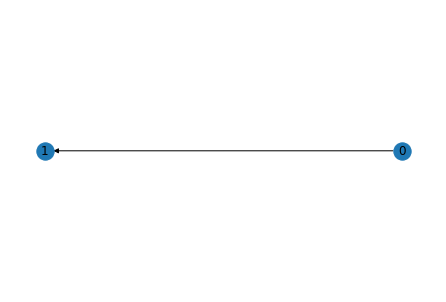

In [14]:
%matplotlib inline

gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub)
gPINN.plotGraph()
print('Vin:', gPINN.Vin)
print('Vout:', gPINN.Vout)
gPINN.E
gPINN.pos

Draw collocation points uniformly or take them equidistantly distributed.

In [15]:
mode = 'deterministic'
mode = 'uniform'

N_0 = 1000
N_b = 1000
N_r = 4000

# Set random seed for reproducible results
tf.random.set_seed(0)

def drawCollocationPoints(N_0, N_b, N_r):
    X_r = tf.random.uniform((N_r,2), lb, ub, dtype=DTYPE)
    
    # Draw uniform sample points for initial boundary data
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    
    # Boundary data
    t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
    x_l = tf.ones((N_b,1), dtype=DTYPE) * lb[1]
    X_l = tf.concat([t_b, x_l], axis=1)
    
    x_u = tf.ones((N_b,1), dtype=DTYPE) * ub[1]
    X_u = tf.concat([t_b, x_u], axis=1)
    
    X_b = tf.concat([X_l, X_u], axis=0)

    # Draw uniformly sampled collocation points
    t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    # X_data = tf.concat([X_0, X_b, X_r], axis=0)
    return X_r, X_0, X_l, X_u

if mode == 'deterministic':

    # Uniform distributed collocation points
    t_r = tf.linspace(lb[0], ub[0], N_0+1)
    x_r = tf.linspace(lb[1], ub[1], N_b+1)
    tt, xx = tf.meshgrid(t_r,x_r)
    X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)

elif mode == 'uniform':
    
    X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #X_data = tf.concat([X_0, X_b, X_r], axis=0)

Draw collocation points.

Text(0, 0.5, 'x')

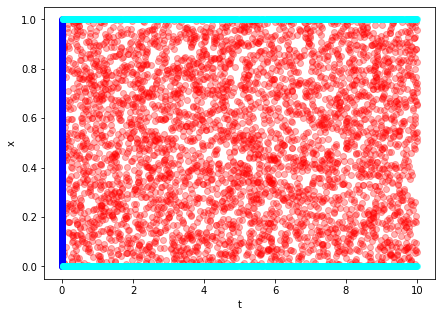

In [16]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0].numpy(), X_r[:,1].numpy(),color='red',alpha=0.3)
ax.scatter(X_0[:,0].numpy(), X_0[:,1].numpy(), color='blue', alpha=0.5)
ax.scatter(X_u[:,0].numpy(), X_u[:,1].numpy(), color='cyan', alpha=0.5)
ax.scatter(X_l[:,0].numpy(), X_l[:,1].numpy(), color='cyan', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel('x')

## Set up class for time-dependent equations

We have to handle different kinds of boundary and vertex conditions:
- all inner vertices: Kirchhoff-Neumann conditon
- initial time conditions on all edges
- Dirichlet conditions on selected vertices as long as it is an inflowing node

Here we call the functions (_fvals1, _fvals2) that explicitly calculate the derivatives for us. For this we use 'tf.vectorized_map', which decomposes a tensor along the axis 0, applies the given functions (get_gradient, get_gradient_and_hessian) to the individual rows and returns a nested tensor with the results.  

In [17]:
from time import time

class graphPINNSolver(object):
    def __init__(self, graphPINN, Xr, X0, Xl, Xu):
        
        self.graphPINN = graphPINN
        self.ne = self.graphPINN.ne
        
        self._updateData(Xr, X0, Xl, Xu)
        
        

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(self.ne):
            self.graphPINN.NNs[i](tf.constant([[1., 1.]], dtype=DTYPE))
            self.trainable_variables.append(self.graphPINN.NNs[i].trainable_variables)
        
        # Setup auxiliary variables for vertex values to ensure continuity
        self._setupVertexVariables()
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            self.trainable_variables.append([self.vertexVals[i]])
        
        self.nvar = len(self.trainable_variables)
        
    def _updateData(self, Xr, X0, Xl, Xu):
        self.Xr = Xr
        self.X0 = X0
        self.Xl = Xl
        self.Xu = Xu
        
        self.nr = Xr.shape[0]
        self.n0 = X0.shape[0]
        self.nb = Xl.shape[0]

    def _setupVertexVariables(self):
        
        self.vertexVals = []
        for _ in self.graphPINN.innerVertices:
            self.vertexVals.append(tf.Variable(tf.random.uniform(shape=(self.nb,), dtype=DTYPE), trainable=True))

    def _fvals0(self, tx):

        # Initialize lists for values and derivatives
        u = []
        for i in range(self.ne):
            u.append(self.graphPINN.NNs[i](tx)[:,0])

        return u
    
    def _fvals1(self, tx):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        
        for i in range(self.ne):
            result = tf.vectorized_map(self.graphPINN.NNs[i].get_gradient, tx)
            u.append(tf.reshape(result[0], [-1]))
            ut.append(tf.reshape(result[1][:,0], [-1]))
            ux.append(tf.reshape(result[1][:,1], [-1]))
                            
        return [tf.concat(u, 0)], [tf.concat(ut, 0)], [tf.concat(ux, 0)]
    
    def _fvals2(self, tx):
        
        u = []
        ux = []
        ut = []
        uxx = []
        
        for i in range(self.ne):
            result = tf.vectorized_map(self.graphPINN.NNs[i].get_gradient_and_hessian, tx)
            u.append(tf.reshape(result[0], [-1]))
            ut.append(tf.reshape(result[1][:,0], [-1]))
            ux.append(tf.reshape(result[1][:,1], [-1]))
            uxx.append(result[2][:,0,0])
                            
        return [tf.concat(u, 0)], [tf.concat(ut, 0)], [tf.concat(ux, 0)], [tf.concat(uxx, 0)]
    
    
    def _fvals2_for(self, tx):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        uxx = []
        
        for i in range(self.ne):
            for j in range(tx.shape[0]):
                output, gradient, hessian = self.graphPINN.NNs[i].get_gradient_and_hessian(tf.reshape(tx[j,:], [1,2]))
                u.append(output)
                ut.append(gradient[0])
                ux.append(gradient[1])
                uxx.append(hessian[0, 0])

                            
        return u, ut, ux, uxx
    
    def _fvals2_ad(self, t, x):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        uxx = []
        
        for i in range(self.ne):
            
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(t)
                tape.watch(x)

                tx = tf.stack([t, x], axis=1)

                # Compute current values u(t,x)
                u.append(self.graphPINN.NNs[i](tx)[:,0])
                ux.append(tape.gradient(u[i], x))
                
            ut.append(tape.gradient(u[i], t))
            uxx.append(tape.gradient(ux[i], x))
            
            del tape
        
        return u, ut, ux, uxx
    
    def determine_losses(self):
        # Short-hand notation of mean-squared loss
        mse = lambda x : tf.reduce_mean(tf.square(x))
        
        ###################################
        ### Residual loss for all edges ###
        ###################################
        # u, ut, ux, uxx = self._fvals2(self.Xr[:,0], self.Xr[:,1])
        u, ut, ux, uxx = self._fvals2(self.Xr)
        
        loss_res = 0
        for i in range(self.ne):
            res_e = pde(u[i], ut[i], ux[i], uxx[i])
            loss_res += mse(res_e)
        
        
        ###################################
        ### Initial conds for all edges ###
        ###################################
        
        # u = self._fvals0(self.X0[:,0], self.X0[:,1])
        u = self._fvals0(self.X0)
        
        loss_init = 0
        for i in range(self.ne):
            res_e = u[i] - initial_cond(self.X0[:,1])
            loss_init += mse(res_e)
        
        ###################################
        ###   Continuity in vertices    ###
        ###################################
        
        # ul, ult, ulx = self._fvals1(self.Xl[:,0], self.Xl[:,1])
        # uu, uut, uux = self._fvals1(self.Xu[:,0], self.Xu[:,1])
        ul, ult, ulx = self._fvals1(self.Xl)
        uu, uut, uux = self._fvals1(self.Xu)
        
        
        loss_cont = 0
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            
            for j in self.graphPINN.Vin[v]:
                val = uu[j] - self.vertexVals[i]
                loss_cont += mse(val)

            for j in self.graphPINN.Vout[v]:
                val = ul[j] - self.vertexVals[i]
                loss_cont += mse(val)

        #####################################
        ### Kirchhoff-Neumann in vertices ###
        #####################################
        
        # Kirchhoff-Neumann condition in center nodes
        loss_KN = 0
        for i in self.graphPINN.innerVertices:
            
            val = 0
            print('Kirchhoff-Neumann in node ', i)
            for j in self.graphPINN.Vin[i]:
                print('incoming edge:', j)
                val += flux(uu[j], uux[j])
                
            for j in self.graphPINN.Vout[i]:
                print('outgoing edge:', j)
                val -= flux(ul[j], ulx[j])
            loss_KN += mse(val)
        
        #####################################
        ###      Inflow/Outflow conds     ###
        #####################################
            
        loss_D = 0
        for i,v in enumerate(self.graphPINN.dirichletNodes):
            
            if time_dependent:
                alpha = self.graphPINN.dirichletAlpha[i](self.Xl[:,0])
                beta = self.graphPINN.dirichletBeta[i](self.Xl[:,0])
            else:
                alpha = self.graphPINN.dirichletAlpha[i]
                beta = self.graphPINN.dirichletBeta[i]
            
            print('\nin node ', v, 'alpha ', alpha, 'beta ', beta)
            val = 0
            for j in self.graphPINN.Vin[v]:
                print('outflow: ', j)
                val += flux(uu[j], uux[j]) \
                    - beta * (uu[j])
                #loss_D += mse(val)

            for j in self.graphPINN.Vout[v]:
                print('inflow: ', j)
                val += -flux(ul[j], ulx[j]) \
                    + alpha * (1-ul[j])
                #loss_D += mse(val)
            loss_D += mse(val)
        print(loss_res)
        print(loss_init)
        print(loss_cont)
        print(loss_KN)
        print(loss_D)
        return loss_res, loss_init, loss_cont, loss_KN, loss_D
    
    def loss_fn(self):
        
        loss_res, loss_init, loss_cont, loss_KN, loss_D = self.determine_losses()
        
        loss = loss_res + loss_init + loss_cont + loss_KN + loss_D

        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 20 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [18]:
#solver.graphPINN.NNs[0](tf.constant([[1., 1.]]))

In [19]:
gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub)
N_0 = 1000
N_b = 1000
N_r = 4000
solver = graphPINNSolver(gPINN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 1 neural nets.


Check accuracy of explicit derivatives in relation to gradient tape (automatic differentiation).  

In [20]:
tf.random.set_seed(1234)
X_test = tf.random.uniform((10,2), dtype=DTYPE)
u, ut, ux, uxx = solver._fvals2(X_test)
u_ad, ut_ad, ux_ad, uxx_ad = solver._fvals2_ad(X_test[:,0], X_test[:,1])

In [21]:
# print(u)
# print(ut)
# print(ux)
# print(uxx)

In [22]:
# print(u_ad)
# print(ut_ad)
# print(ux_ad)
# print(uxx_ad)

In [23]:
print(tf.concat(u, 0)-tf.concat(u_ad, 0))
print(tf.concat(ut, 0)-tf.concat(ut_ad, 0))
print(tf.concat(ux, 0)-tf.concat(ux_ad, 0))
print(tf.concat(uxx, 0)-tf.concat(uxx_ad, 0))

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor(
[ 0.00000000e+00  0.00000000e+00 -1.73472348e-18  0.00000000e+00
  8.67361738e-19  1.73472348e-18 -8.67361738e-19 -8.67361738e-19
 -4.33680869e-19  0.00000000e+00], shape=(10,), dtype=float64)
tf.Tensor(
[-8.67361738e-19  0.00000000e+00  0.00000000e+00 -8.67361738e-19
 -8.67361738e-19  0.00000000e+00 -8.67361738e-19  0.00000000e+00
  0.00000000e+00  0.00000000e+00], shape=(10,), dtype=float64)
tf.Tensor(
[0.00057618 0.00066879 0.00041448 0.00101092 0.00115857 0.00102376
 0.00045867 0.00089013 0.00084862 0.00127524], shape=(10,), dtype=float64)


The question remains what is more accurate for the second partial derivative. 

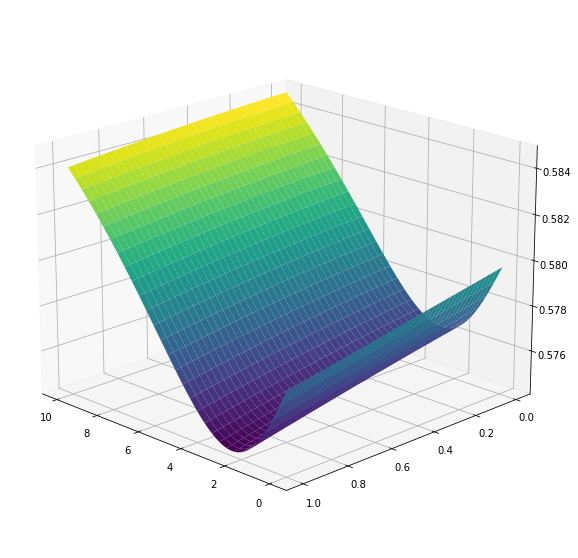

In [24]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


In [25]:
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver.solve_with_TFoptimizer(optim, N=2001)
#for i in range(20):
    # WARNING: Update of collocation points currently not supported
    # Vertex values are fixed for coordinates at boundary!
    #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #solver._updateData(X_r, X_0, X_l, X_u)
    #solver.solve_with_TFoptimizer(optim, N=301)


Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  3.85242035e-01   9.78
00020  1.18021633e-01   12.56
00040  7.95453848e-02   15.10
00060  6.55200948e-02   17.52
00080  5.45349670e-02   20.23
00100  4.27842493e-02   22.91
00120  3.06322198e-02   25.44
00140  2.24180371e-02   28.50
00160  1.94047445e-02   31.83
00180  1.77820986e-02   35.16
00200  1.66683174e-02   38.43
00220  1.57466261e-02   41.78
00240  1.49332426e-02   45.15
00260  1.41891803e-02   48.99
00280  1.35139748e-02   52.30
00300  1.29154583e-02   55.53
00320  1.23850047e-02   58.89
00340  1.19098616e-02   61.93
00360  1.14803202e-02   65.10
00380  1.10913340e-02   68.06
00400  1.07396804e-02   70.93
00420  1.04215010e-02   73.91
00440  1.01324858e-02   76.87
0046

In [26]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*1)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 2000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 2000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  4.43321285e-03   2.79
02040  4.02079451e-03   5.64
02060  3.87243160e-03   9.05
02080  3.80003960e-03   12.17
02100  3.74393036e-03   15.34
02120  3.72992378e-03   18.29
02140  3.69602243e-03   21.49
02160  3.67549266e-03   24.51
02180  3.65129037e-03   27.85
02200  3.62839395e-03   31.15
02220  3.59226876e-03   34.58
02240  3.54694560e-03   38.18
02260  3.50669507e-03   42.17
02280  3.43655228e-03   45.50
02300  3.36819005e-03   48.92
02320  3.23861555e-03   52.61
02340  2.88718529e-03   57.49
02360  2.54796419e-03   60.44
02380  2.29886765e-03   63.44
02400  2.13913948e-03   66.28
02420  2.03646273e-03   69.39
02440  1.95234965e-03   73.07
02460  1.90398692e-03   76.30
02480  1.89488975e-03   79.80
02500  1.88290515e-03   83.10
02520  1.84790088e-03   86.52
02540  1.83901272e-03   90.30
02560  1.82389633e-03   93.38
02580  1.81001183e-03   96.54
02600  1.78828544e-03   100.01
02620  1.77883

In [27]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig = plt.figure(1, figsize=(10, 10))
#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
def plot_network(j=0):
    fig = plt.figure(1,clear=True)
    ax = fig.add_subplot(1,1,1, projection='3d')
    t0 = tf.ones_like(xspace)*tspace[j]
    pos = solver.graphPINN.pos
    for i, e in enumerate(solver.graphPINN.E):
        xy = pos[e[0]] + xspace*(pos[e[1]] - pos[e[0]]) / (ub[1]-lb[1])
        #xy = pos[e[0].numpy()] + xspace*(pos[e[1].numpy()] - pos[e[0].numpy()]) 
        #xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = solver.graphPINN.NNs[i](tf.concat([t0,xspace],axis=1))
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
        #ax.plot(xy[:,0], xy[:,1], unum * (1-unum))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([.0,1.0])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(12, 135)
    return u

j_slider = widgets.IntSlider(min=0,max=Nt,step=1)
interactive_plot = interactive(plot_network, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

interactive(children=(IntSlider(value=0, description='j', max=60), Output()), _dom_classes=('widget-interact',…

<Figure size 720x720 with 0 Axes>

Surface plot of function values on a single edge.

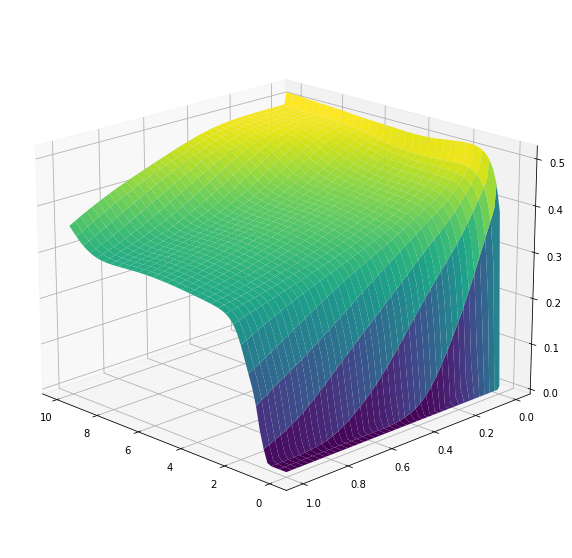

In [28]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)
